In [0]:
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

def plot_mean_and_CI(mean, lb, ub, color_shading=None):
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.9)
    plt.plot(mean, 'r')

In [0]:
#class for environment

class environment():
    
    #environment initializer
    
    def __init__(self, init_s):
        
        #ititial temperature and degree of ventilation
        
        self.t, self.vent_degree = init_s
        
    #step of environment, driven by a
        
    def step(self, a):
        
        #control parameters
        
        heat, vent = a
        
        #update of parameters
        
        self.t = self.t - 0.01*self.t + 0.5*heat + 0.04*vent - 0.002*self.t*vent - 0.0005*self.t ** 2
        
        #checking of boundaries
        
        if self.t<0:
            self.t = 0
        elif self.t>35:
            self.t = 35
            
        self.vent_degree = self.vent_degree - (1 - vent) + 3*vent
        
        if self.vent_degree<0:
            self.vent_degree = 0
        elif self.vent_degree>60:
            self.vent_degree = 60
            
        #return new parameters of environment
            
        return self.t, self.vent_degree
      
    #sample session with random control

    def random_session(self, num_of_steps, sigma):
        collection_a = []
        collection_t = []
        collection_noisy_t = []
        t = self.t
        noisy_t = t
        a = 3
        for i in range(num_of_steps):
            collection_t.append(t)
            collection_noisy_t.append(noisy_t)
            if 0.3 > np.random.rand():
                a = np.random.choice(4)
            collection_a.append(a)
            a_for_agent = np.unravel_index(a, (2, 2))
            t, _ = self.step(a_for_agent)
            noisy_t = t + sigma*np.random.randn()
        return np.array(collection_t), np.array(collection_noisy_t), np.array(collection_a)

In [0]:
#generate training set
env = environment((20, 20))
t, noisy_t, a = env.random_session(300 * 16, 1.)
t = t.reshape((1, 16, 300))
noisy_t = noisy_t.reshape((1, 16, 300))
a = a.reshape((1, 16, 300))

We need to minimize the following expression:
$$\sum_{i=1}^{N}\left[\log(\sqrt{2\pi}s)+\log(\sqrt{2\pi}\eta)+\frac{(T_i - \xi_i(T))^2}{2s^2} + \frac{\sigma^2_i(T)}{2s^2} + \frac{\sigma^2_i(T)}{2\eta^2} + \frac{\xi_i^2(T) + \left\langle F(\sigma_{i-1}(T)\epsilon_{i-1} + \xi_{i-1}(T))^2\right\rangle - 2\xi_i(T)\left\langle F(\sigma_{i-1}(T)\epsilon_{i-1} + \xi_{i-1}(T))\right\rangle}{2\eta^2} + \log\left[\sqrt{2\pi}\sigma_i(T)\right] + \frac{1}{2}\right]$$

In [0]:
#conv 1d layer, is needed for denoising
def conv_1d_layer(input_value, channels_in, channels_out, name, activation=True, filter_size=16):
    with tf.name_scope(name):
        w = tf.get_variable(shape=(filter_size, channels_in, channels_out), name='w'+name, initializer=tf.initializers.he_uniform())
        b = tf.Variable(tf.zeros([channels_out]), name='b'+name)
        conv = tf.nn.conv1d(input_value, w, 1, "SAME", name='conv')
        if activation == True:
            act = tf.nn.relu(conv + b)
        else:
            act = conv + b
    return act

In [6]:
# length of one session
session_length = 300

#min and max temperature
t_min = 0
t_max = 30

tf.reset_default_graph()


#log variances of normal noise in dynamical system and in observations
s = tf.constant(-5, dtype=tf.float32, name='log_variance_transition')
eta = tf.Variable(-5, dtype=tf.float32, name='log_variance_measurement')

#weights which parametrize dynamics of hidden variables
with tf.name_scope('weights'):
    W1 = tf.get_variable(shape=(5, 32), dtype=tf.float32, name='W1')
    b1 = tf.get_variable(shape=(32,), dtype=tf.float32, name='b1')
    W2 = tf.get_variable(shape=(32, 8), dtype=tf.float32, name='W2')
    b2 = tf.get_variable(shape=(8,), dtype=tf.float32, name='b2')
    W3 = tf.get_variable(shape=(8, 1), dtype=tf.float32, name='W3')
    b3 = tf.get_variable(shape=(1,), dtype=tf.float32, name='b3')
    
    
#placeholders for action, state, auxiliary noise
actions_ph = tf.placeholder(shape=(None, session_length), dtype=tf.int32, name='actions_ph')
states_ph = tf.placeholder(shape=(None, session_length), dtype=tf.float32, name='states_ph')
eps_ph = tf.placeholder(shape=(None, session_length), dtype=tf.float32, name='eps_ph')
states_and_actions = tf.concat([tf.expand_dims(tf.cast(actions_ph, dtype=tf.float32), axis=-1)\
                                , tf.expand_dims(states_ph, axis=-1)], axis=-1, name='concat')


#decoder (denoiser)#
conv1 = conv_1d_layer(states_and_actions, 2, 8, filter_size=8, name='conv1')
conv2 = conv_1d_layer(conv1, 8, 32, filter_size=8, name='conv2')
conv3 = conv_1d_layer(conv2, 32, 8, filter_size=8, name='conv3')
state_out = conv_1d_layer(conv3, 8, 2, filter_size=8, name='conv4', activation=False)
with tf.name_scope('separation'):
    #hidden variables
    mu = state_out[:, :, 0]
    #variance of hidden variables
    sigma = state_out[:, :, 1]

#one hot representation of actions
one_hot_action = tf.one_hot(actions_ph, axis=-1, depth=4, name='one_hot_action')

#data preparation before passing through dynamical map
with tf.name_scope('true_state'):
    true_state = mu + tf.exp(sigma/2) * eps_ph
input_for_transformation = tf.concat([one_hot_action, tf.expand_dims(true_state, axis=-1)]\
                                     , axis=-1, name='input_for_transformation')
input_for_transformation = tf.reshape(input_for_transformation, shape=(-1, 5), name='reshape')

#passing through dynamical map
with tf.name_scope('net_in_time'):
    h1 = tf.matmul(input_for_transformation, W1) + b1
    h1 = tf.nn.relu(h1)
    h2 = tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(h2)
    inf_transform = tf.matmul(h2, W3) + b3
    inf_transform = tf.reshape(inf_transform, shape=(-1, session_length))
    F = true_state + inf_transform

#shifting data in time
with tf.name_scope('time_shift'):
    mu = mu[:, 1:]
    sigma = sigma[:, 1:]
    T = states_ph[:, 1:]
    eps = eps_ph[:, 1:]
    F = F[:, :-1]
    
    
#sigma term
with tf.name_scope('sigma_term'):
    sigma_term = tf.exp(sigma) * (1 / (2 * tf.exp(s)) + 1 / (2 * tf.exp(eta)))

#regularization term
with tf.name_scope('regularization_term'):
    regularization_term = tf.pow(mu - F, 2) / (2 * tf.exp(s))
    
#log sigma term
with tf.name_scope('log_sigma_term'):
    log_sigma_term = -sigma/2
    
#regression term
with tf.name_scope('regression_term'):
    regression_term = tf.pow(T - mu, 2) / (2 * tf.exp(eta))

#loss function
with tf.name_scope('loss'):
    loss = tf.reduce_mean(sigma_term + regularization_term + log_sigma_term + regression_term + s/2 + eta/2)#+ tf.exp(tf.nn.relu(-10 - s)) + tf.reduce_mean(tf.nn.relu(-14 - sigma)) + tf.nn.relu(-14 - eta)
    
#training
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.003).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#write to tensorboard
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
writer = tf.summary.FileWriter('/tmp/summary')
writer.add_graph(sess.graph)

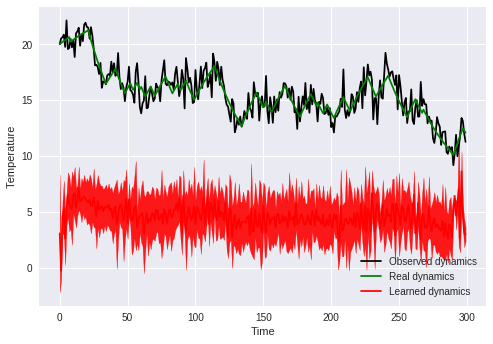

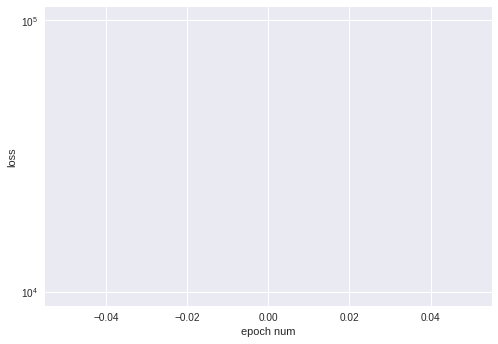

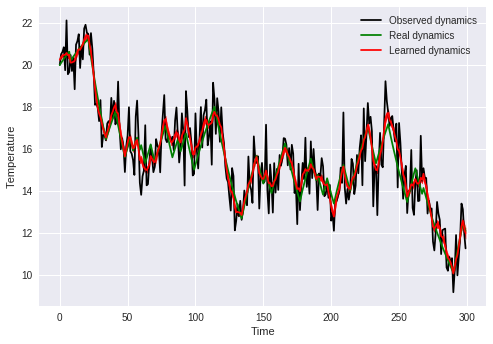

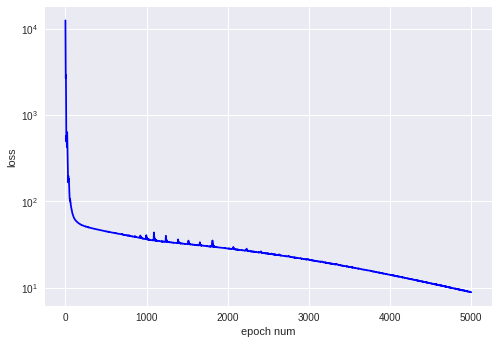

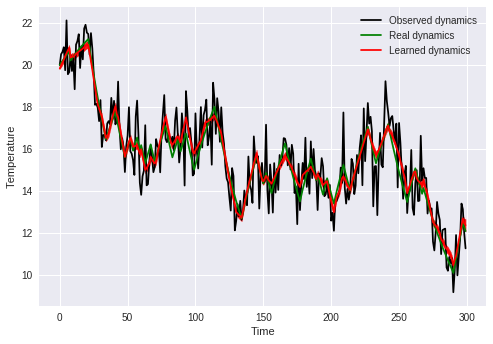

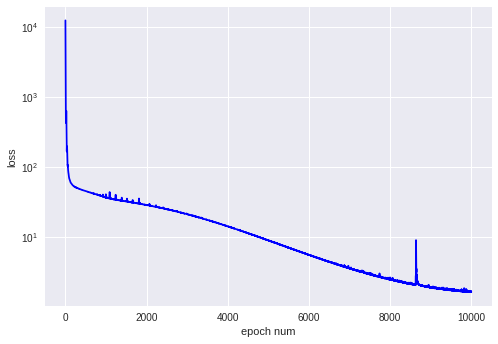

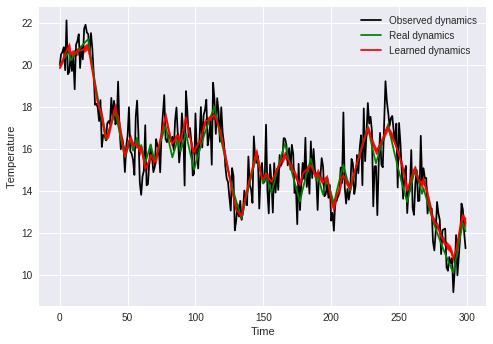

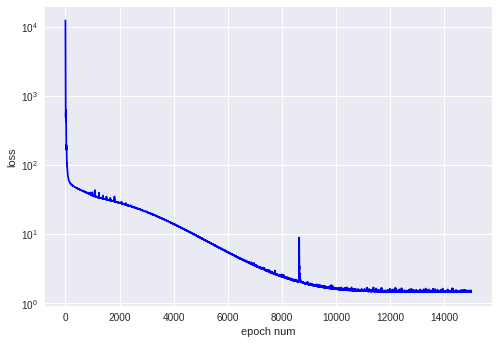

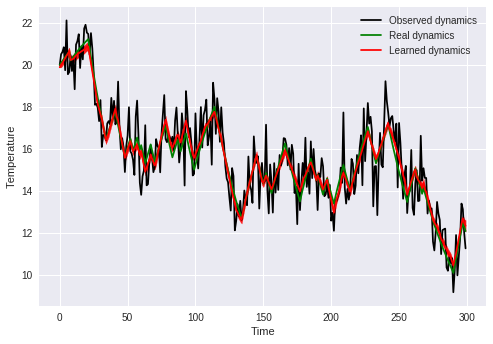

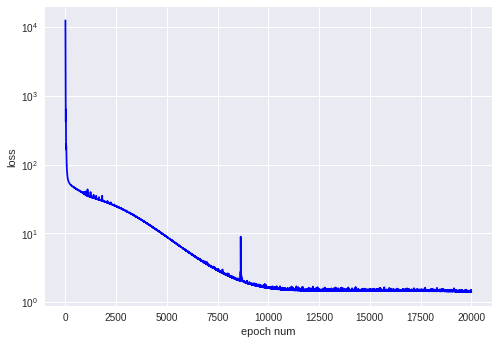

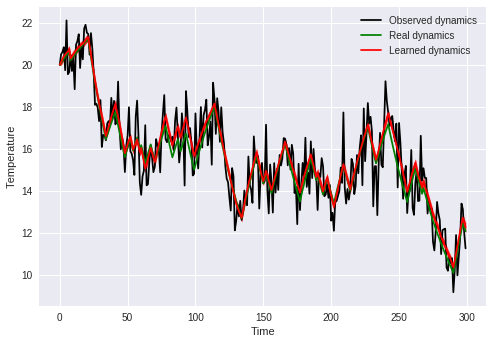

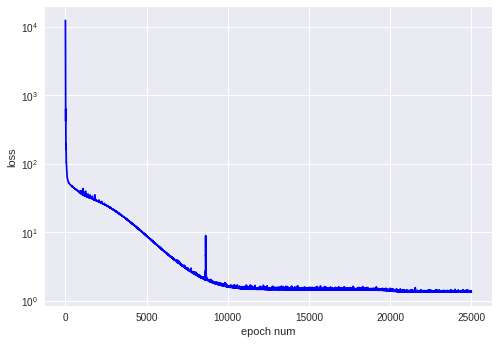

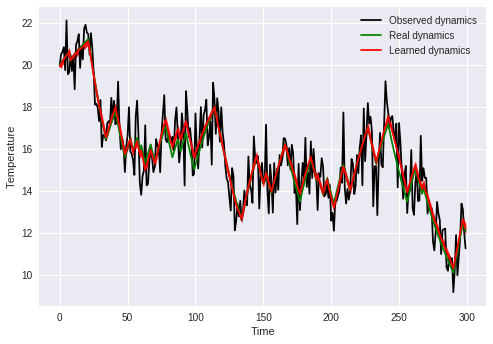

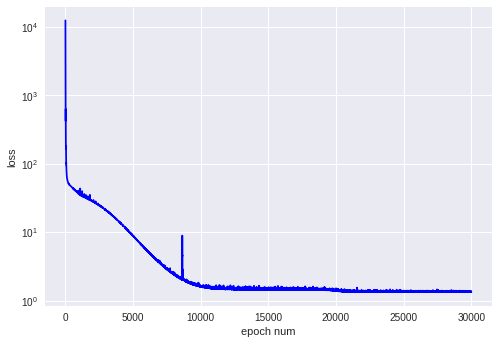

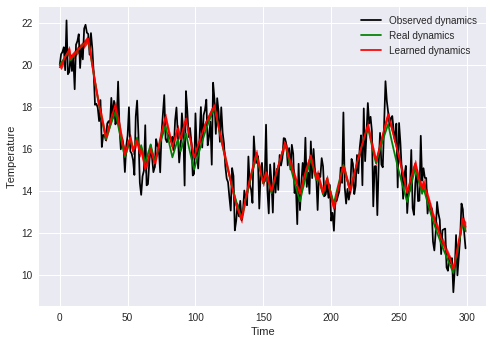

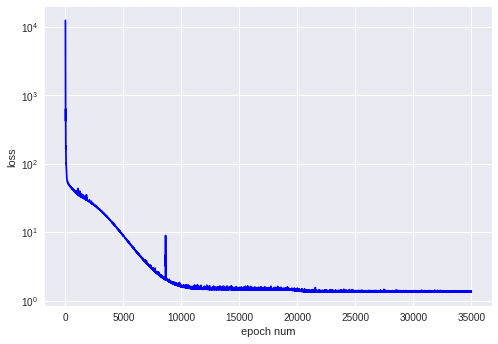

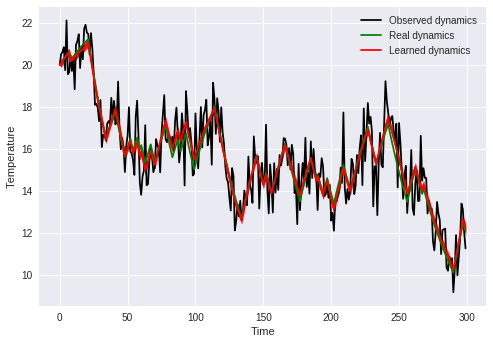

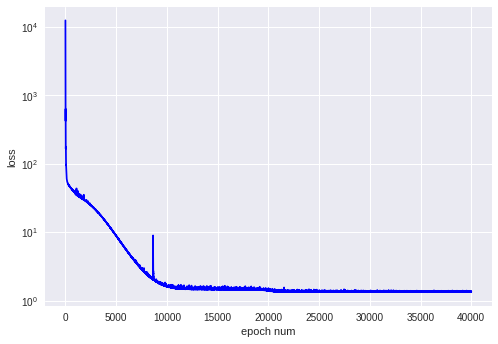

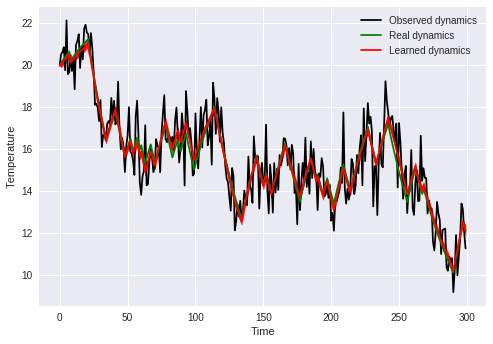

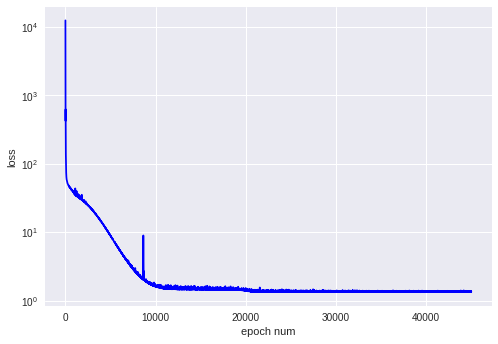

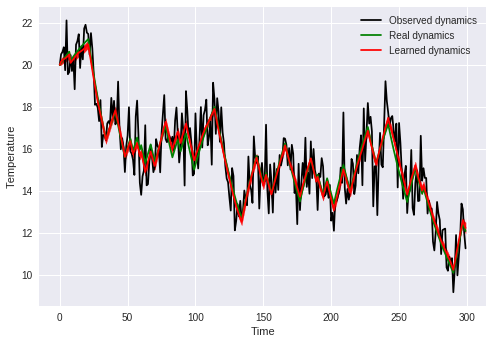

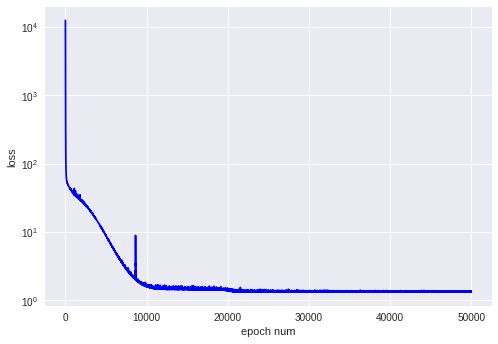

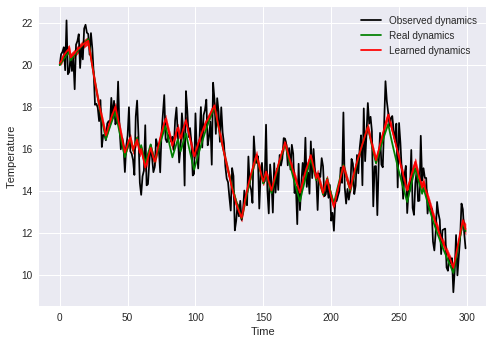

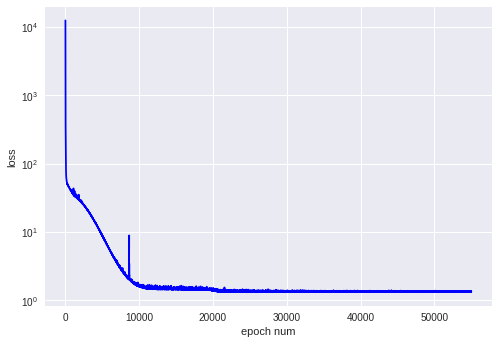

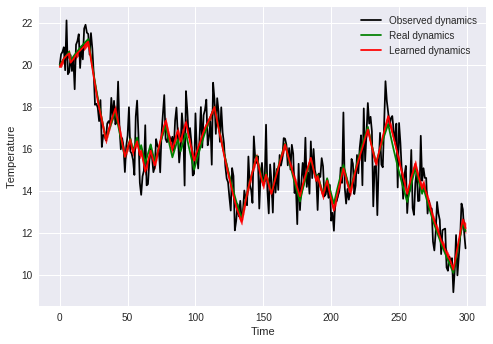

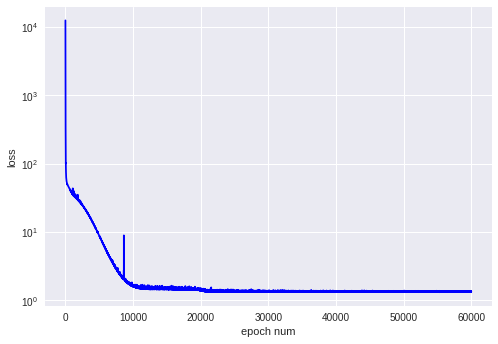

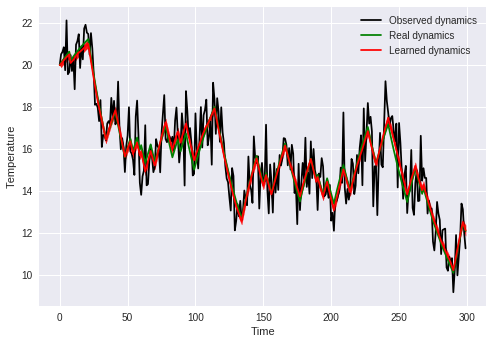

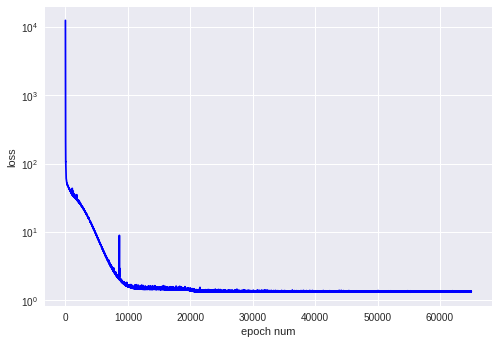

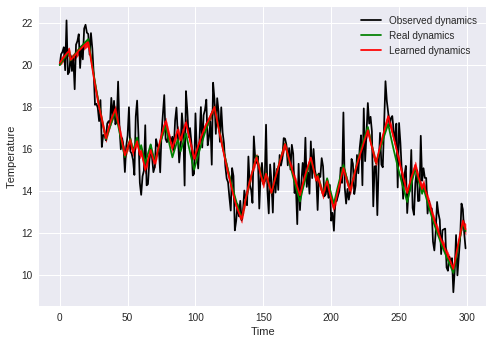

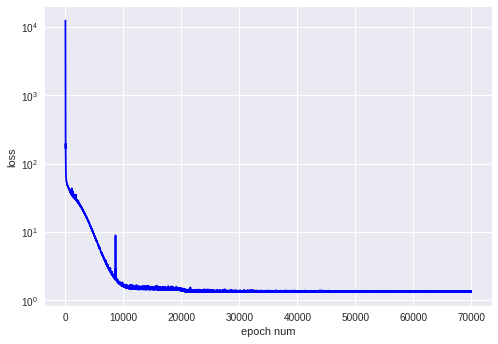

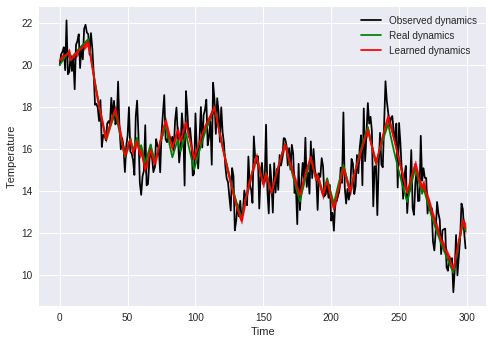

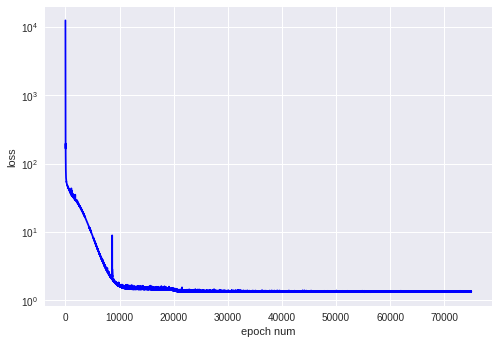

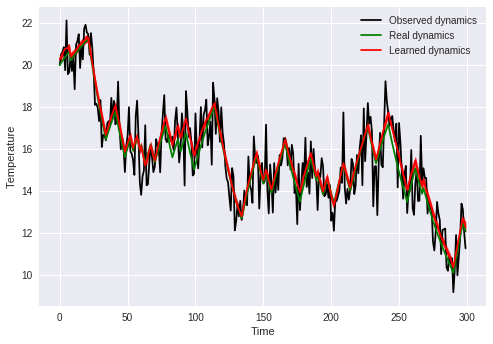

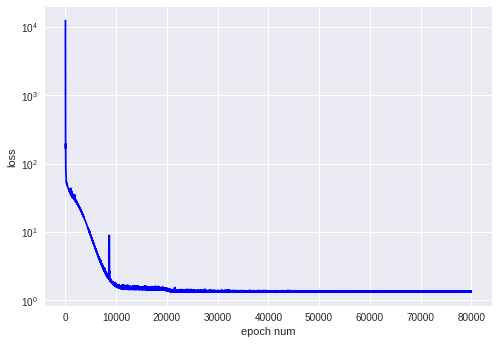

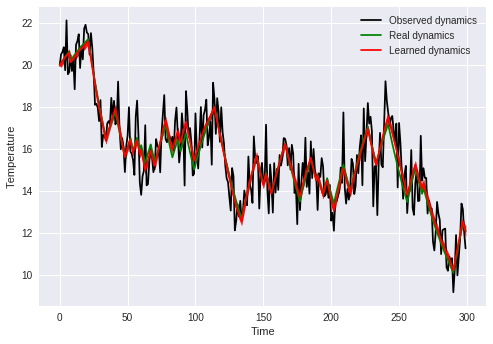

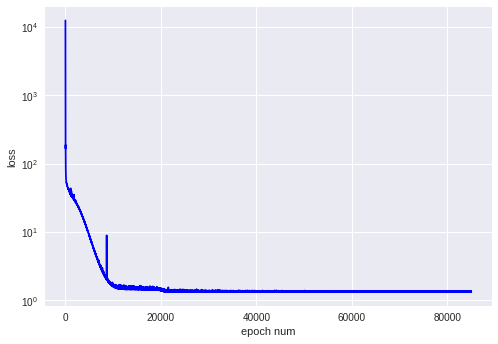

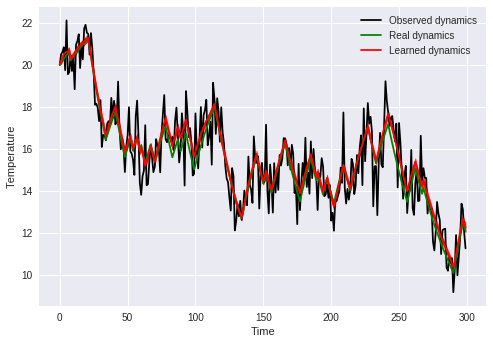

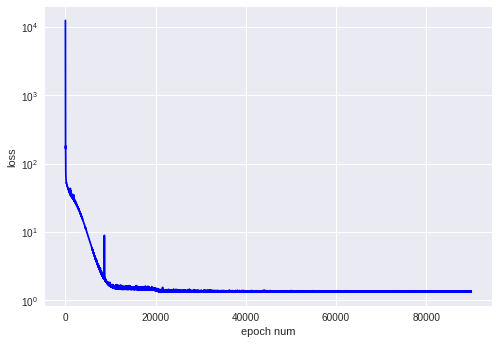

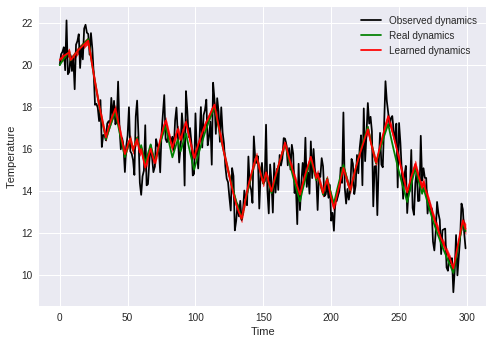

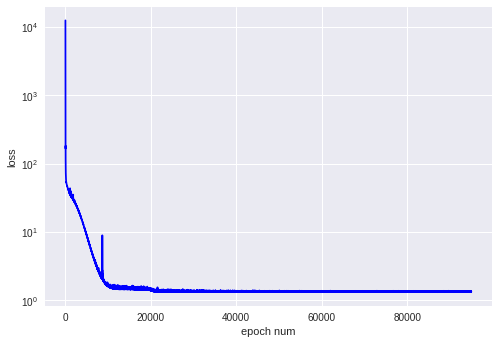

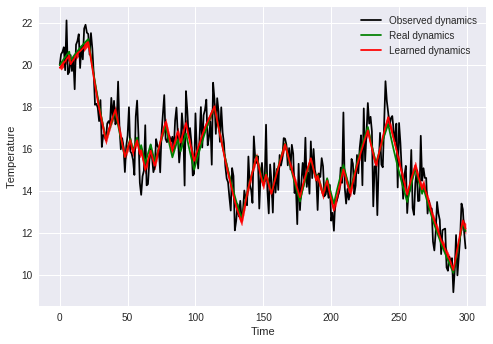

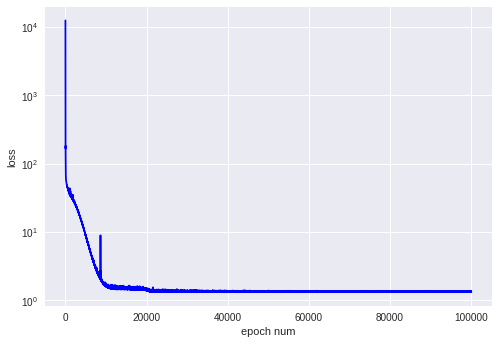

In [13]:
####learning####

#number of epochs
num_epochs = 101000

#session preparaton
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#main loop
losses = []
for i in range(num_epochs):
    l = 0.
    for j in range(1):
        new_l = sess.run([loss, train_step], feed_dict={actions_ph:a[j], states_ph:noisy_t[j], eps_ph:np.random.randn(16, session_length)})[0]
        l = l + new_l
    losses.append(l)
    
    #plotting
    if i%5000 == 0:
        true_t = t[0, 0]
        true_noisy_t = noisy_t[0, 0]
        data = sess.run([state_out], feed_dict={actions_ph:np.expand_dims(a[0, 0], axis=0), states_ph:np.expand_dims(noisy_t[0, 0], axis=0)})[0]
        pred_t = data[0, :, 0]
        sigma = np.exp(data[0, :, 1]/2)
        fig1 = plt.figure()
        plt.ylabel('Temperature')
        plt.xlabel('Time')
        plt.plot(true_noisy_t, 'black')
        plt.plot(true_t, 'green')
        plot_mean_and_CI(pred_t, pred_t - 3*sigma, pred_t + 3*sigma, color_shading='red')
        plt.legend(['Observed dynamics', 'Real dynamics', 'Learned dynamics'])
        plt.savefig(fname='fig'+str(i))
        fig2 = plt.figure()
        plt.ylabel('loss')
        plt.xlabel('epoch num')
        plt.yscale('log')
        plt.plot(losses, 'blue')
        plt.show()

In [0]:
#function for validation
def validation(environment, num_of_steps):
  
        #lists for parameters
        collection_a = []
        collection_t = []
        collection_t_for_net = []
        collection_noisy_t = []
        t = environment.t
        t_for_net = t
        noisy_t = t
        a = 3
        
        #main loop
        for i in range(num_of_steps):
            collection_t.append(t)
            collection_noisy_t.append(noisy_t)
            collection_t_for_net.append(t_for_net)
            collection_a.append(a)
            
            #pick action randomly with probability 0.2
            if 0.2 > np.random.rand():
                a = np.random.choice(4)
            
            #predict dynamics using learned model
            aux = np.zeros(4)
            aux[a] = 1.
            aux = np.append(aux, t_for_net)
            hidden_1 = np.matmul(aux, sess.run(W1)) + sess.run(b1)
            hidden_1 = np.maximum(hidden_1, 0)
            hidden_2 = np.matmul(hidden_1, sess.run(W2)) + sess.run(b2)
            hidden_2 = np.maximum(hidden_2, 0)
            t_for_net = np.matmul(hidden_2, sess.run(W3)) + sess.run(b3) + t_for_net
            #predict dynamics using original model
            a_for_agent = np.unravel_index(a, (2, 2))
            t, _ = environment.step(a_for_agent)
            
            noisy_t = t + sigma*np.random.randn()
            
        return collection_t, collection_noisy_t, collection_t_for_net

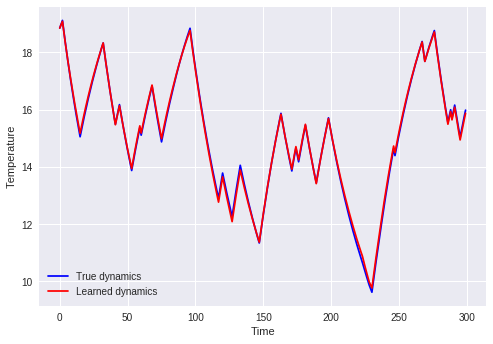

In [23]:
#comparison of true and learned dynamics
true_t, _, predicted_t = validation(env, 300)
q = np.zeros((a.shape[0],4))
q[:, a] = 1
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.plot(true_t, 'blue')
plt.plot(predicted_t, 'red')
plt.legend(['True dynamics', 'Learned dynamics'])

In [0]:
'''

def f_t(t):
  
    actions = np.zeros(t.shape + (4, 4))
    temperatures = np.zeros(t.shape + (4, 1))
    actions[:, :,] = np.eye(4)
    temperatures = temperatures + t.reshape(t.shape + (1, 1))
    aux = np.append(actions, temperatures, axis=-1)
    hidden_1 = np.matmul(aux.reshape((-1, 5)), sess.run(W1)) + sess.run(b1)
    hidden_1 = np.maximum(hidden_1, 0)
    hidden_2 = np.matmul(hidden_1, sess.run(W2)) + sess.run(b2)
    hidden_2 = np.maximum(hidden_2, 0)
    return (np.matmul(hidden_2, sess.run(W3)) + sess.run(b3)).reshape(t.shape + (4,))
  
def f_v(vent):
  
    vents = np.zeros(vent.shape + (4,))
    vents[:, :, [0, 2]] = -1
    vents[:, :, [1, 3]] = 3
    return vents
  
def derivativ(v):
    d_vent = np.zeros_like(v)
    d_t = np.zeros_like(v)
    d_vent[1:-1][:, 1:-1] = (v[:, 2:] - v[:, :-2])[1:-1]
    d_t[1:-1][:, 1:-1] = (v[2:] - v[:-2])[:, 1:-1]
  
    return d_vent, d_t
  
def cost(t, vent):
  
    cost_for_t = -(((t - 20) ** 2) / 2).reshape(t.shape + (1,))
    cost_for_vent = -((60 - vent) / 6).reshape(t.shape + (1,))
    cost_for_a = np.zeros(t.shape + (4,))
    cost_for_a[0] = 0
    cost_for_a[1] = -1
    cost_for_a[2] = -1
    cost_for_a[3] = -2
    return cost_for_t + cost_for_vent + cost_for_a
'''

In [0]:
'''
dt = 0.
dvent = 0.1
vent_max = 60
vent_min = 0
dT = 0.001
gamma = 0.05
t = np.arange(t_min, t_max, dt)
vent = np.arange(vent_min, vent_max, dvent)
vent, t = np.meshgrid(vent, t)
v = -10000 * np.ones(t.shape)
force_t, force_vent = f_t(t), f_v(vent)

for i in range(1000):
    #v[-2:] = -100
    #v[:2] = -100
    #v[:, -2:] = -100
    #v[:, :2] = -100
    v_vent, v_t = derivativ(v)
    v_t = v_t/(2 * dt)
    v_vent = v_vent/(2 * dvent)
    v_next = force_t * np.expand_dims(v_t, axis=-1) +\
    force_vent * np.expand_dims(v_vent, axis=-1)\
    + cost(t, vent) - gamma * np.expand_dims(v, axis=-1)
    v = dT * v_next.max(axis=-1) + v
'''

In [0]:
'''
Input = tf.keras.layers.Input(shape=(2,), dtype=tf.float32, name='input')
h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(Input)
h2 = tf.keras.layers.Dense(32, activation='relu', name='h2')(h1)
probs = tf.keras.layers.Dense(4, activation='softmax', name='softmax')(h2)
logits = tf.keras.layers.Dense(4, activation=None, name='softmax')(h2)
policy = tf.keras.Model(inputs=Input, outputs=probs)
policy_logits = tf.keras.Model(inputs=Input, outputs=logits)

q_ph = tf.placeholder(shape=(None,), dtype=tf.float32, name='imput_q')
a_ph = tf.placeholder(shape=(None, 4), dtype=tf.float32, name='imput_a')
s_ph = tf.placeholder(shape=(None, 2), dtype=tf.float32, name='imput_s')

loss_control = -tf.reduce_mean(q_ph * tf.reduce_sum(a_ph * tf.nn.log_softmax(policy_logits(s_ph), axis=-1)))
train_step_control = tf.train.AdamOptimizer(0.0001).minimize(loss_control)
'''

In [0]:
'''
weights = {}

weights['W1'] = sess.run(W1)
weights['W2'] = sess.run(W2)
weights['W3'] = sess.run(W3)
weights['b1'] = sess.run(b1)
weights['b2'] = sess.run(b2)
weights['b3'] = sess.run(b3)

def lerned_dynamics(a, T, vent, weights=weights):
    
    one_hot_a = np.zeros(4)
    one_hot_a[a] = 1.
    hidden_1 = np.matmul(np.append(one_hot_a, T), weights['W1']) + weights['b1']
    hidden_1 = np.maximum(hidden_1, 0)
    hidden_2 = np.matmul(hidden_1, weights['W2']) + weights['b2']
    hidden_2 = np.maximum(hidden_2, 0)
    T_new = (np.matmul(hidden_2, weights['W3']) + weights['b3'] + T)[0]
    
    vent_new = vent + (np.array([-1, 3, -1, 3]) * one_hot_a).sum()
    
    return T_new, vent_new

def gen_session(length_of_session, T_in=20, vent_in=30):
    r_collection = []
    a_collection = []
    s_collection = []
    
    T = T_in
    vent = vent_in
    for j in range(length_of_session):
        
        state = np.array([T, vent])
        a = np.random.choice(4, p=policy.predict(np.expand_dims(state, axis=0))[0])
        one_hot_a = np.zeros(4)
        one_hot_a[a] = 1.
        r = -(((T - 18) ** 2) / 4 + 0.1 * (30 - vent) * (vent < 30) +  0.1 * (vent - 60) * (vent > 60) + (np.array([0, 1, 1, 2]) * one_hot_a).sum())
        r_collection.append(r)
        a_collection.append(one_hot_a)
        s_collection.append(state)
    
        T, vent = lerned_dynamics(a, T, vent)
      
    return r_collection, s_collection, a_collection

def reward_to_q(rewards, gamma):
    q = [rewards[-1]]
    for r in rewards[::-1][1:]:
        q = [(r + gamma*q[0])] + q
    return np.array(q).T
  
def gen_batch(length_of_session, gamma=0.95, T_in=20, vent_in=30):
  
    r, s, a = gen_session(length_of_session, T_in, vent_in)
    q = reward_to_q(r, gamma)
    return np.array(s), np.array(a), np.array(q), np.array(r).mean()
  
def train_step(sess):
    
    s, a, q, r = gen_batch(1000, gamma=0.95, T_in=20, vent_in=30)
    l, _ = sess.run([loss_control, train_step_control], feed_dict={s_ph:s, a_ph:a, q_ph:q})
    return r, s, l
'''

In [0]:
'''
sess_control = tf.Session()
init = tf.global_variables_initializer()
sess_control.run(init)
state = []
vents = []
rewards = []
for i in range(50):
    r, s, l = train_step(sess_control)
    rewards.append(r)
    state.append(s)
    losses.append(l)
'''

In [0]:
with tf.name_scope('q_weights'):
    q_W1 = tf.get_variable(shape=(2, 16), dtype=tf.float32, name='q_W1')
    q_b1 = tf.get_variable(shape=(16,), dtype=tf.float32, name='q_b1')
    q_W2 = tf.get_variable(shape=(16, 16), dtype=tf.float32, name='q_W2')
    q_b2 = tf.get_variable(shape=(16,), dtype=tf.float32, name='q_b2')
    q_W3 = tf.get_variable(shape=(16, 4), dtype=tf.float32, name='q_W3')
    q_b3 = tf.get_variable(shape=(4,), dtype=tf.float32, name='q_b3')
    
with tf.name_scope('q_weights_mean'):
    q_W1_mean = tf.get_variable(shape=(2, 16), dtype=tf.float32, name='q_W1_mean')
    q_b1_mean = tf.get_variable(shape=(16,), dtype=tf.float32, name='q_b1_mean')
    q_W2_mean = tf.get_variable(shape=(16, 16), dtype=tf.float32, name='q_W2_mean')
    q_b2_mean = tf.get_variable(shape=(16,), dtype=tf.float32, name='q_b2_mean')
    q_W3_mean = tf.get_variable(shape=(16, 4), dtype=tf.float32, name='q_W3_mean')
    q_b3_mean = tf.get_variable(shape=(4,), dtype=tf.float32, name='q_b3_mean')

In [0]:
gamma = 0.95
alpha = 0.9

with tf.name_scope('place_holders_for_q_net'):
    s_old_ph = tf.placeholder(shape=(None, 2), dtype=tf.float32, name='input_state_old')
    s_new_ph = tf.placeholder(shape=(None, 2), dtype=tf.float32, name='input_state_new')
    r_ph = tf.placeholder(shape=(None,), dtype=tf.float32, name='input_state')
    action_ph = tf.placeholder(shape=(None,), dtype=tf.int32, name='input_action')
    
one_hot_action = tf.one_hot(action_ph, 4, axis=-1, name='one_hot_action')

with tf.name_scope('q_old'):
    q_h11 = tf.matmul(s_old_ph, q_W1) + q_b1
    q_h11 = tf.nn.relu(q_h11)
    q_h12 = tf.matmul(q_h11, q_W2) + q_b2
    q_h12 = tf.nn.relu(q_h12)
    q_old = tf.matmul(q_h12, q_W3) + q_b3
    
q_W1_mean = q_W1_mean * alpha + q_W1 * (1 - alpha)
q_W2_mean = q_W2_mean * alpha + q_W2 * (1 - alpha)
q_W3_mean = q_W3_mean * alpha + q_W3 * (1 - alpha)
q_b1_mean = q_b1_mean * alpha + q_b1 * (1 - alpha)
q_b2_mean = q_b2_mean * alpha + q_b2 * (1 - alpha)
q_b3_mean = q_b3_mean * alpha + q_b3 * (1 - alpha)
    
with tf.name_scope('q_new'):
    q_h21 = tf.matmul(s_new_ph, q_W1_mean) + q_b1_mean
    q_h21 = tf.nn.relu(q_h21)
    q_h22 = tf.matmul(q_h21, q_W2_mean) + q_b2_mean
    q_h22 = tf.nn.relu(q_h22)
    q_new = tf.matmul(q_h22, q_W3_mean) + q_b3_mean

with tf.name_scope('loss_function_q_net'):
    loss_control = tf.reduce_mean(tf.pow(tf.reduce_sum(q_old * one_hot_action, axis=-1) - \
                                     tf.stop_gradient(r_ph + gamma * tf.reduce_max(q_new, axis=-1)), 2))
with tf.name_scope('traing_q_net'):
    train_step_control = tf.train.AdamOptimizer(learning_rate=0.0001, beta2=0.99).minimize(loss_control)


T = tf.expand_dims(s_old_ph[:, 0], axis=-1)
input_for_transformation = tf.concat([one_hot_action, T]\
                                     , axis=-1, name='input_for_transformation_q')

with tf.name_scope('time_evolution_q'):
    h1 = tf.matmul(input_for_transformation, W1) + b1
    h1 = tf.nn.relu(h1)
    h2 = tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(h2)
    inf_transform = tf.matmul(h2, W3) + b3
    F = T + inf_transform
    new_state = F

In [0]:
sess_control = tf.Session()
init = tf.global_variables_initializer()
sess_control.run(init)

batch_size = 1000
ls = []
for j in range(100000):
    T_old = (6 + t_max - t_min) * np.random.rand(batch_size) - 3
    vent_old = 80 * np.random.rand(batch_size) - 10
    state_old = np.append(np.expand_dims(T_old, axis=-1), np.expand_dims(vent_old, axis=-1), axis=-1)
    
    #if 0.5 > np.random.rand():
    #    a = sess_control.run(q_old, feed_dict={s_old_ph:state_old}).argmax(-1)
    #else:
    #    a = np.random.choice(4, batch_size)
    a = np.random.choice(4, batch_size)
    one_hot_a = np.zeros((a.shape[0], 4))
    one_hot_a[np.arange(a.shape[0]), a] = 1
    
    T_new = sess_control.run(new_state, feed_dict={s_old_ph:state_old, action_ph:a})[:, 0]
    vent_new = vent_old + (np.array([-1, 3, -1, 3]) * one_hot_a).sum(-1)
    state_new = np.append(np.expand_dims(T_new, axis=-1), np.expand_dims(vent_new, axis=-1), axis=-1)

    rewards = -(2 * (T_old > 21) * (T_old - 21) + 2 * (T_old < 18) * (18 - T_old) + 2 * (vent_old < 30) * (30 - vent_old)\
                + 2 * (vent_old > 60) * (vent_old - 60) + (one_hot_a * np.array([0., 1., 1., 2.])).sum(-1))

    l, _ = sess_control.run([loss_control, train_step_control], \
                            feed_dict={s_old_ph:state_old, s_new_ph:state_new, r_ph:rewards, action_ph:a})
    ls.append(l)

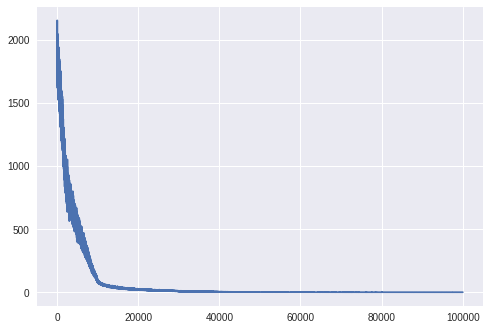

In [133]:
 plt.plot(ls)

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


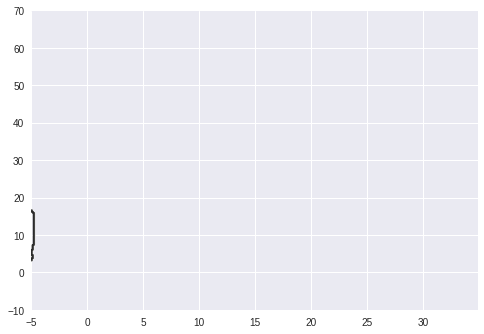

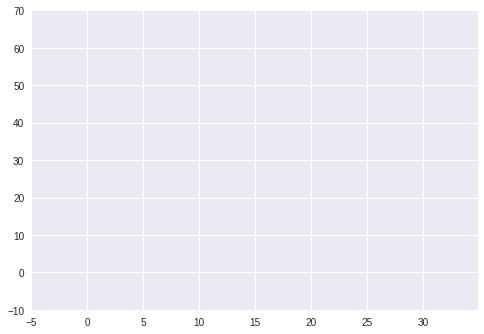

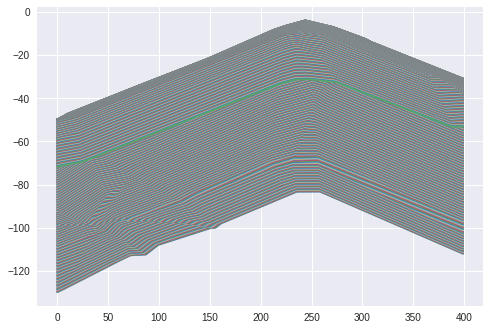

In [134]:
def q_function(sess, input_s):
    q_h11 = np.matmul(input_s, sess.run(q_W1)) + sess.run(q_b1)
    q_h11 = np.maximum(q_h11, 0)
    q_h12 = np.matmul(q_h11, sess.run(q_W2)) + sess.run(q_b2)
    q_h12 = np.maximum(q_h12, 0)
    return np.matmul(q_h12, sess.run(q_W3)) + sess.run(q_b3)

t = np.arange(-5, 35, 0.1)
vent = np.arange(-10, 70, 0.1)
t, vent = np.meshgrid(t, vent)
policy = np.unravel_index(q_function(sess_control, np.append(np.expand_dims(t, axis=-1), np.expand_dims(vent, axis=-1), axis=-1).reshape(-1, 2)).argmax(-1).reshape(t.shape), (2, 2))
v = q_function(sess_control, np.append(np.expand_dims(t, axis=-1), np.expand_dims(vent, axis=-1), axis=-1).reshape(-1, 2)).max(-1).reshape(t.shape)
#plt.imshow(v)
#plt.plot(v.T)
fig1 = plt.figure()
plt.contour(t, vent, policy[0])
fig2 = plt.figure()
plt.contour(t, vent, policy[1])
fig3 = plt.figure()
plt.plot(v.T)

In [0]:
def session_under_control(self, sess, num_of_steps, sigma):
        collection_a = []
        collection_vent = []
        collection_t = []
        t = self.t
        noisy_t = t
        a = 3
        for i in range(num_of_steps):
            collection_t.append(t)
            collection_vent.append(self.vent_degree)
            state_fot_net = np.expand_dims(np.array([self.t, self.vent_degree]), axis=0)
            a = q_function(sess, state_fot_net).argmax(-1)[0]
            a_for_agent = np.unravel_index(a, (2, 2))
            collection_a.append(a)
            t, _ = self.step(a_for_agent)
            noisy_t = t + sigma*np.random.randn()
        return np.array(collection_t), np.array(collection_vent), np.array(collection_a)

In [0]:
env = environment((-5, 60))
T, v, a = session_under_control(env, sess_control, 300, 0.1)

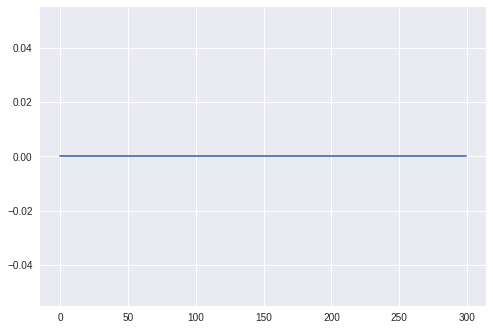

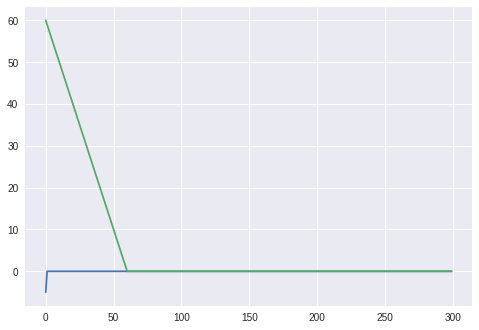

In [137]:
fig3 = plt.figure()
plt.plot(a)
fig4 = plt.figure()
plt.plot(T)
plt.plot(v)

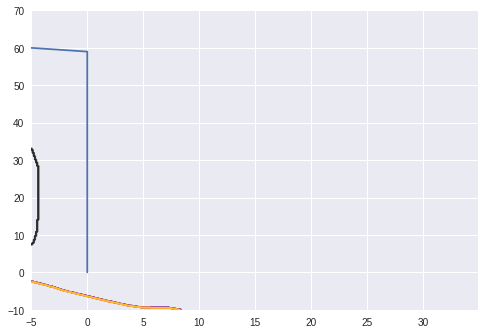

In [121]:
plt.contour(t, vent, policy[0])
plt.contour(t, vent, policy[1], cmap='plasma')
plt.plot(T, v)